# Import dependencies

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import pandas as pd
import numpy as np
import glob

api = KaggleApi()
api.authenticate()

dataset_ref = 'altavish/boston-housing-dataset'
download_path = '../data/raw'

os.makedirs(download_path, exist_ok=True)
api.dataset_download_files(dataset_ref, path=download_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/altavish/boston-housing-dataset


### Let's predict median home value (MEDV) based on neighborhood features using Polynomial Regression

# EDA

In [2]:
csv_file = glob.glob(os.path.join(download_path, '*.csv'))[0]
df = pd.read_csv(csv_file)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [4]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
print(f"Duplicates: {df.duplicated().sum()}")
print(f"Nulls per column:\n{df.isnull().sum()}")
print(f"\nUnique values per column:\n{df.nunique()}")

Duplicates: 0
Nulls per column:
CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

Unique values per column:
CRIM       484
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        348
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      438
MEDV       229
dtype: int64


506 samples with 14 columns. The target is MEDV (median home value in $1000s). Six columns have 20 nulls each: CRIM, ZN, INDUS, CHAS, AGE, and LSTAT. That's about 4% missing per column, well under the 5% threshold, so median imputation is fine. No duplicates. 

The features cover crime rate, zoning, industrial proportion, proximity to the Charles River, air quality (NOX), rooms (RM), age of buildings, distances, highway access (RAD), tax rate, pupil-teacher ratio, demographics (B), and lower-status population percentage (LSTAT).

In [29]:
# Impute missing values with median
for col in df.columns:
    n_null = df[col].isnull().sum()
    if n_null > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"  {col}: {n_null} nulls -> median ({median_val:.2f})")

print(f"\nRemaining nulls: {df.isnull().sum().sum()}")


Remaining nulls: 0


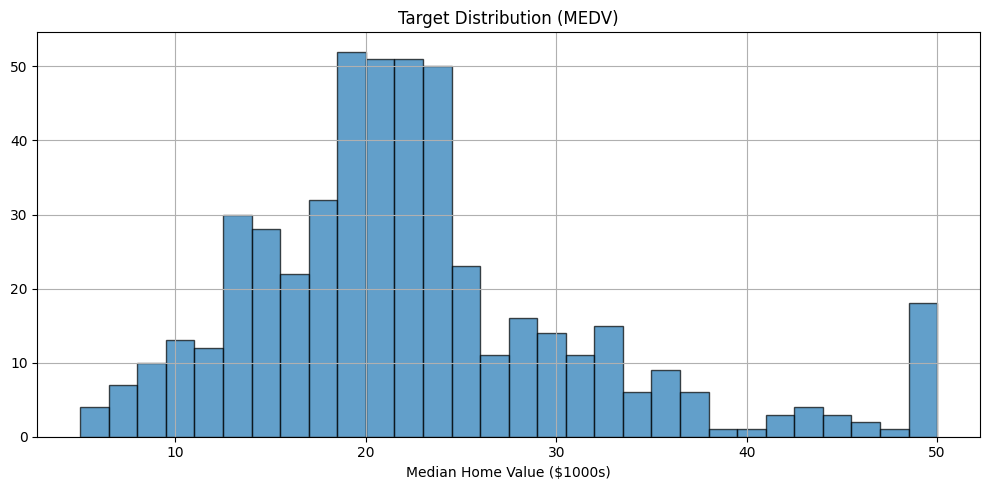

Skewness: 1.10
Kurtosis: 1.47


In [30]:
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

y = df['MEDV']

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=30, edgecolor='k', alpha=0.7)
ax.set_title('Target Distribution (MEDV)')
ax.set_xlabel('Median Home Value ($1000s)')
ax.grid(True)
plt.tight_layout()
plt.show()

print(f"Skewness: {skew(y):.2f}")
print(f"Kurtosis: {kurtosis(y):.2f}")

Skewness of 1.10 means the target is right-skewed, there's a cluster of homes around $20-25k and a long tail of expensive ones. There's also a suspicious spike at $50k which looks like a cap (values were truncated at 50). Kurtosis of 1.47 confirms the heavy tail. The skew is above 1.0 so a log transform might help the residuals later, but let's try without it first and check assumptions after fitting.

In [8]:
# Outlier detection
from scipy import stats

X_all = df.drop(columns=['MEDV'])
z_scores = np.abs(stats.zscore(X_all))
outlier_rows = (z_scores > 3).any(axis=1)
print(f"Outlier rows (Z > 3): {outlier_rows.sum()} / {len(df)}")

Outlier rows (Z > 3): 103 / 506


103 outlier rows, about 20% of the data. That's too many to remove. Features like CRIM (crime rate) and B (demographic index) have naturally extreme distributions. These are real data patterns not errors. Keeping everything.

In [9]:
# Correlation with target
import seaborn as sns

corr_target = X_all.corrwith(df['MEDV']).sort_values(ascending=False)
print("Correlation with MEDV:")
print(corr_target)

Correlation with MEDV:
RM         0.695360
ZN         0.362292
B          0.333461
DIS        0.249929
CHAS       0.183844
AGE       -0.377572
RAD       -0.381626
CRIM      -0.383895
NOX       -0.427321
TAX       -0.468536
INDUS     -0.476394
PTRATIO   -0.507787
LSTAT     -0.723093
dtype: float64


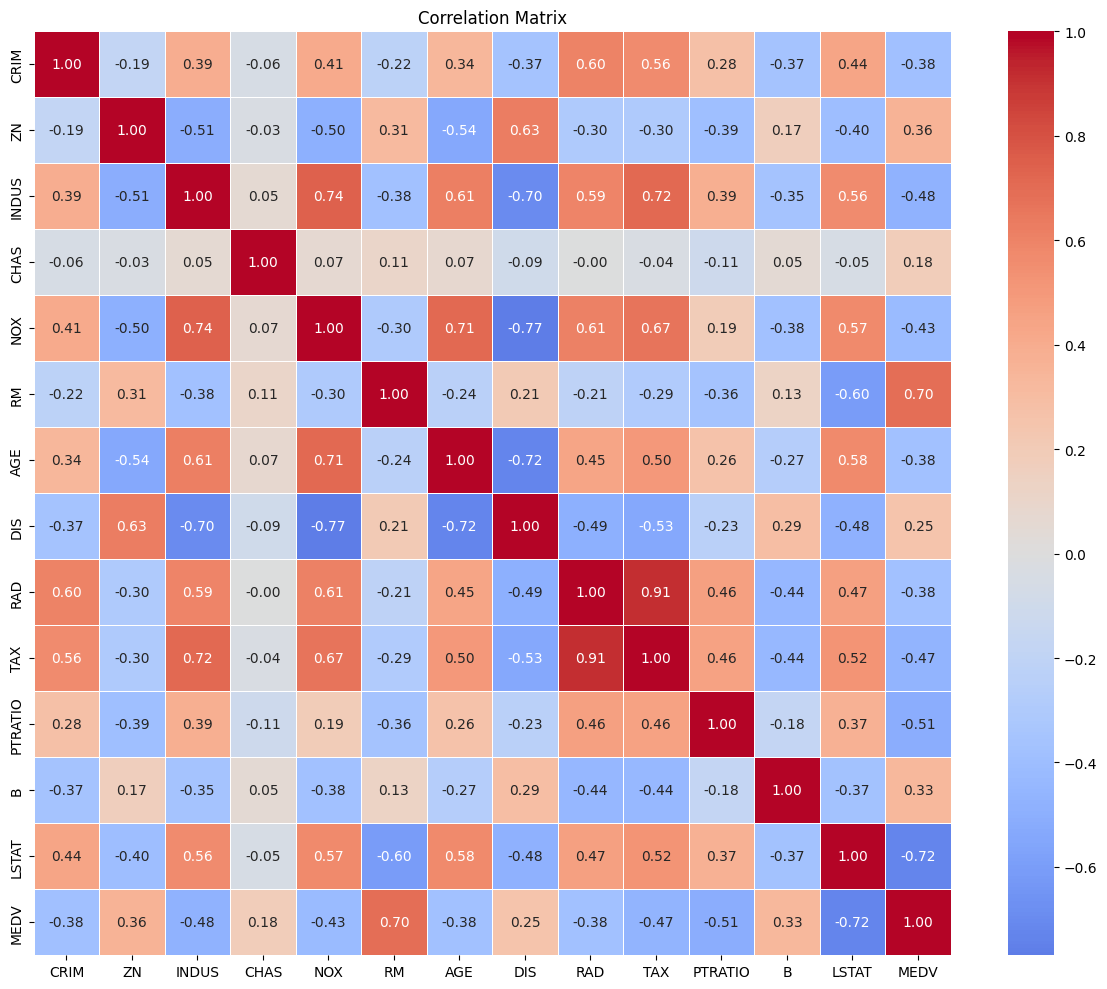

In [10]:
# Correlation heatmap
corr = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

LSTAT (-0.72) and RM (0.70) are the two strongest predictors of home value by a wide margin. LSTAT (% lower status population) has a strong negative correlation, RM (average rooms) has a strong positive one. Both make intuitive sense. The next strongest are PTRATIO (-0.51) and INDUS (-0.48), decent but much weaker. There's also high multicollinearity: RAD and TAX at 0.91, NOX and DIS at -0.77, INDUS and NOX at 0.74. For the polynomial regression exercise we'll focus on LSTAT and RM to keep the feature count manageable since polynomial expansion grows combinatorially.

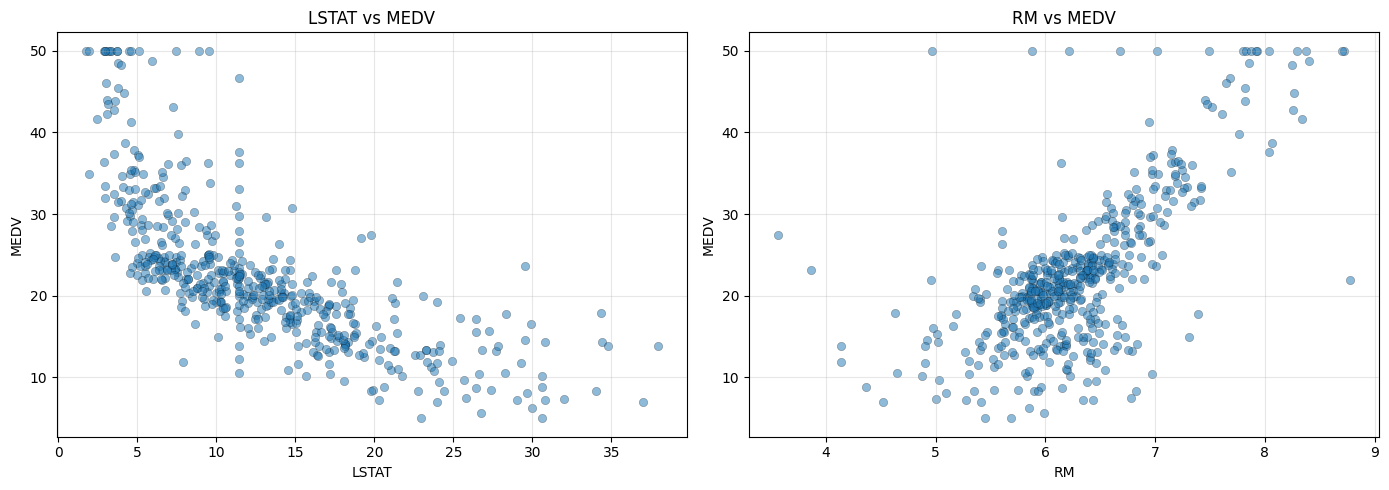

In [11]:
# Scatter plots: LSTAT and RM vs MEDV
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df['LSTAT'], df['MEDV'], alpha=0.5, edgecolors='k', linewidths=0.3)
axes[0].set_xlabel('LSTAT')
axes[0].set_ylabel('MEDV')
axes[0].set_title('LSTAT vs MEDV')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df['RM'], df['MEDV'], alpha=0.5, edgecolors='k', linewidths=0.3)
axes[1].set_xlabel('RM')
axes[1].set_ylabel('MEDV')
axes[1].set_title('RM vs MEDV')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Both scatter plots show clear non-linear patterns. LSTAT vs MEDV follows a curved downward trend, not a straight line. A linear fit would systematically overpredict in the middle range and underpredict at the extremes. RM vs MEDV is roughly linear in the middle but the relationship steepens for homes with many rooms (above 7). These are exactly the kinds of patterns polynomial regression is designed to capture.

# Feature Engineering

In [12]:
# Select features and prepare target
X = df[['LSTAT', 'RM']].copy()
y = df['MEDV'].copy()

print(f"Features: {list(X.columns)}")
print(f"Shape: {X.shape}")

Features: ['LSTAT', 'RM']
Shape: (506, 2)


In [13]:
# VIF check
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.to_string(index=False))

Feature      VIF
  LSTAT 3.339958
     RM 3.339958


VIF of 3.34 for both features, well below the 5 threshold. No multicollinearity between LSTAT and RM, which makes sense since they measure different things (socioeconomic status vs house size). This is a clean starting point for polynomial expansion. Note that after we add polynomial terms (LSTAT^2, RM^2, LSTAT*RM) the VIF will spike because polynomial terms are inherently correlated with their base features, but that's expected and not a problem as long as we don't overinterpret individual coefficients.

In [14]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set:     {X_test.shape[0]} samples")

Training set: 404 samples, 2 features
Test set:     102 samples


In [15]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature means after scaling (should be ~0):", X_train_scaled.mean(axis=0).round(2))
print("Feature stds after scaling (should be ~1):", X_train_scaled.std(axis=0).round(2))

Feature means after scaling (should be ~0): [ 0. -0.]
Feature stds after scaling (should be ~1): [1. 1.]


Scaling is critical for polynomial regression. Without it, LSTAT^2 would range up to ~1400 while RM stays around 4-9. That kind of scale difference makes regularization useless (it would penalize the large-scale features unfairly) and can cause numerical instability in the higher-degree terms. Scaling first, then expanding polynomials, keeps everything on the same scale.

In [16]:
# Baseline model
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score

baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train_scaled, y_train)
baseline_pred = baseline.predict(X_test_scaled)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"Baseline (predict mean): RMSE = {baseline_rmse:.4f}, R² = {r2_score(y_test, baseline_pred):.4f}")

Baseline (predict mean): RMSE = 8.6629, R² = -0.0233


Baseline RMSE is 8.66 and R-squared is basically zero. Predicting the mean home value every time explains nothing. This is the floor.

# Linear Regression (degree 1)

In [17]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_train_pred_lr = lr.predict(X_train_scaled)
y_test_pred_lr = lr.predict(X_test_scaled)

train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))

print(f"Train RMSE: {train_rmse_lr:.4f}, R²: {r2_score(y_train, y_train_pred_lr):.4f}")
print(f"Test  RMSE: {test_rmse_lr:.4f}, R²: {r2_score(y_test, y_test_pred_lr):.4f}")
print(f"\nCoefficients: LSTAT={lr.coef_[0]:.4f}, RM={lr.coef_[1]:.4f}")
print(f"Intercept: {lr.intercept_:.4f}")

Train RMSE: 5.6095, R²: 0.6378
Test  RMSE: 5.6103, R²: 0.5708

Coefficients: LSTAT=-4.2411, RM=4.0829
Intercept: 22.7965


Linear regression gives a test R-squared of 0.57 and RMSE of 5.61. That's a big improvement over the baseline but still leaves 43% of the variance unexplained. The scatter plots showed curved relationships, so a straight line is leaving signal on the table. Let's check the residuals to confirm.

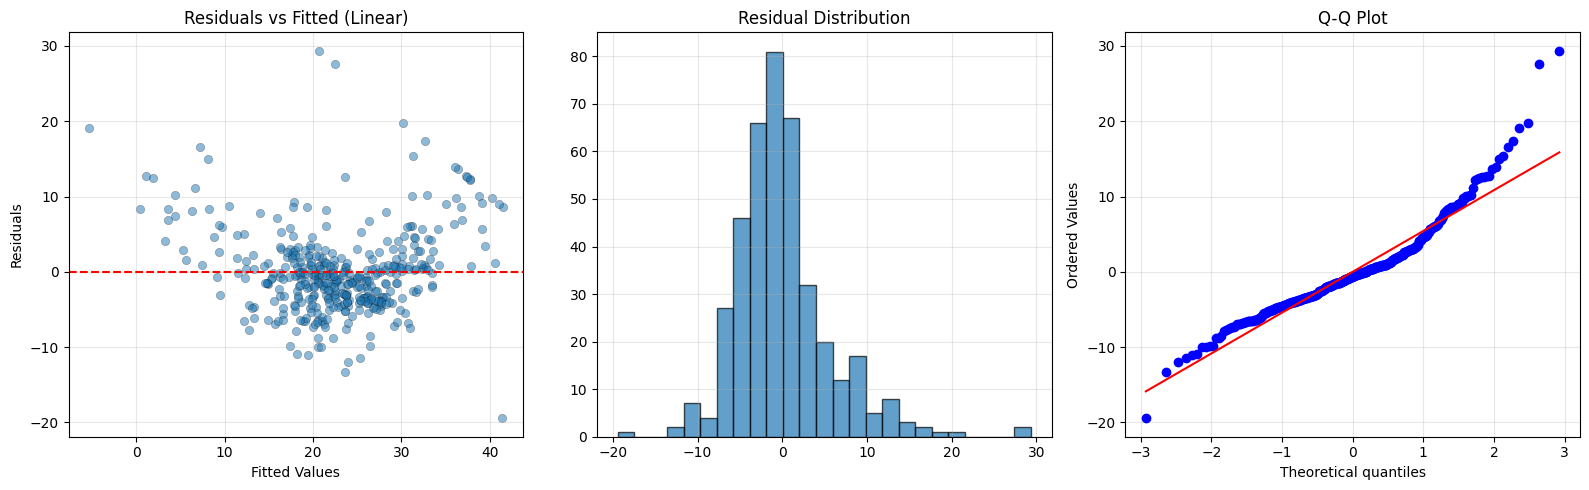

In [18]:
# Residual analysis (linear)
residuals_lr = y_train.values - y_train_pred_lr

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].scatter(y_train_pred_lr, residuals_lr, alpha=0.5, edgecolors='k', linewidths=0.3)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted (Linear)')
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals_lr, bins=25, edgecolor='k', alpha=0.7)
axes[1].set_title('Residual Distribution')
axes[1].grid(True, alpha=0.3)

from scipy.stats import probplot
probplot(residuals_lr, plot=axes[2])
axes[2].set_title('Q-Q Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Assumption checks (linear)
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from scipy.stats import shapiro

dw = durbin_watson(residuals_lr)
X_with_const = sm.add_constant(X_train_scaled)
bp_stat, bp_p, _, _ = het_breuschpagan(residuals_lr, X_with_const)
shap_stat, shap_p = shapiro(residuals_lr)

print(f"Durbin-Watson: {dw:.4f}  (≈2 = no autocorrelation)")
print(f"Breusch-Pagan: p-value = {bp_p:.4f}  (>0.05 = homoscedastic)")
print(f"Shapiro-Wilk:  p-value = {shap_p:.6f}  (>0.05 = normal)")

Durbin-Watson: 2.1837  (≈2 = no autocorrelation)
Breusch-Pagan: p-value = 0.5486  (>0.05 = homoscedastic)
Shapiro-Wilk:  p-value = 0.000000  (>0.05 = normal)


The residuals-vs-fitted plot shows a clear U-shape pattern, which is the classic sign that a linear model is missing non-linear structure. The model overpredicts in the middle and underpredicts at both ends. Durbin-Watson at 2.18 is fine (no autocorrelation) and Breusch-Pagan at 0.55 says homoscedasticity holds, but Shapiro-Wilk fails badly (p ≈ 0), so the residuals aren't normal. The non-normality plus the curved residual pattern both point to the same thing: we need polynomial terms.

In [20]:
# Cross-validation (linear)
from sklearn.model_selection import cross_val_score

cv_r2_lr = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
cv_rmse_lr = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')

print(f"CV R²:   {cv_r2_lr.mean():.4f} +/- {cv_r2_lr.std():.4f}")
print(f"CV RMSE: {(-cv_rmse_lr).mean():.4f} +/- {(-cv_rmse_lr).std():.4f}")

CV R²:   0.6181 +/- 0.0646
CV RMSE: 5.6959 +/- 0.4532


CV R-squared of 0.62 is consistent with the test R-squared of 0.57, so the linear model isn't overfitting, it's just underfitting. The gap between what the data contains and what a straight line can capture is real. Time to add polynomial features.

# Polynomial Regression

In [21]:
from sklearn.preprocessing import PolynomialFeatures

# Degree 2
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly2 = poly2.fit_transform(X_train_scaled)
X_test_poly2 = poly2.transform(X_test_scaled)

print(f"Polynomial features (degree 2): {poly2.get_feature_names_out()}")
print(f"Feature count: {X_train_poly2.shape[1]}")

lr_poly2 = LinearRegression()
lr_poly2.fit(X_train_poly2, y_train)
y_train_pred_p2 = lr_poly2.predict(X_train_poly2)
y_test_pred_p2 = lr_poly2.predict(X_test_poly2)

print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_p2)):.4f}, R²: {r2_score(y_train, y_train_pred_p2):.4f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_p2)):.4f}, R²: {r2_score(y_test, y_test_pred_p2):.4f}")

Polynomial features (degree 2): ['x0' 'x1' 'x0^2' 'x0 x1' 'x1^2']
Feature count: 5

Train RMSE: 4.7233, R²: 0.7432
Test  RMSE: 4.2903, R²: 0.7490


Degree 2 jumps to test R-squared of 0.75 and RMSE of 4.29, a major improvement over the linear model (0.57 / 5.61). The polynomial expansion created 5 features from the original 2: LSTAT, RM, LSTAT^2, LSTAT*RM, and RM^2. The squared terms capture the curvature we saw in the scatter plots, and the interaction term (LSTAT*RM) models how the effect of LSTAT on home value depends on the number of rooms and vice versa.

In [22]:
# Degree 3
poly3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly3 = poly3.fit_transform(X_train_scaled)
X_test_poly3 = poly3.transform(X_test_scaled)

lr_poly3 = LinearRegression()
lr_poly3.fit(X_train_poly3, y_train)
y_train_pred_p3 = lr_poly3.predict(X_train_poly3)
y_test_pred_p3 = lr_poly3.predict(X_test_poly3)

print(f"Degree 3 features: {X_train_poly3.shape[1]}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_p3)):.4f}, R²: {r2_score(y_train, y_train_pred_p3):.4f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_p3)):.4f}, R²: {r2_score(y_test, y_test_pred_p3):.4f}")

Degree 3 features: 9
Train RMSE: 4.5295, R²: 0.7638
Test  RMSE: 6.0708, R²: 0.4974


In [23]:
# Degree 4
poly4 = PolynomialFeatures(degree=4, include_bias=False)
X_train_poly4 = poly4.fit_transform(X_train_scaled)
X_test_poly4 = poly4.transform(X_test_scaled)

lr_poly4 = LinearRegression()
lr_poly4.fit(X_train_poly4, y_train)
y_train_pred_p4 = lr_poly4.predict(X_train_poly4)
y_test_pred_p4 = lr_poly4.predict(X_test_poly4)

print(f"Degree 4 features: {X_train_poly4.shape[1]}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_p4)):.4f}, R²: {r2_score(y_train, y_train_pred_p4):.4f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_p4)):.4f}, R²: {r2_score(y_test, y_test_pred_p4):.4f}")

Degree 4 features: 14
Train RMSE: 4.2618, R²: 0.7909
Test  RMSE: 5.7268, R²: 0.5528


Classic overfitting pattern. Degree 3 has better training performance (R² 0.76) but much worse test performance (R² 0.50) compared to degree 2 (R² 0.74 / 0.75). Degree 4 is even worse on the test set. As the polynomial degree goes up, the model fits the training noise more tightly but generalizes worse. The train-test gap keeps growing: 0.01 for degree 2, 0.27 for degree 3, 0.24 for degree 4. Degree 2 is the sweet spot here.

# Evaluation

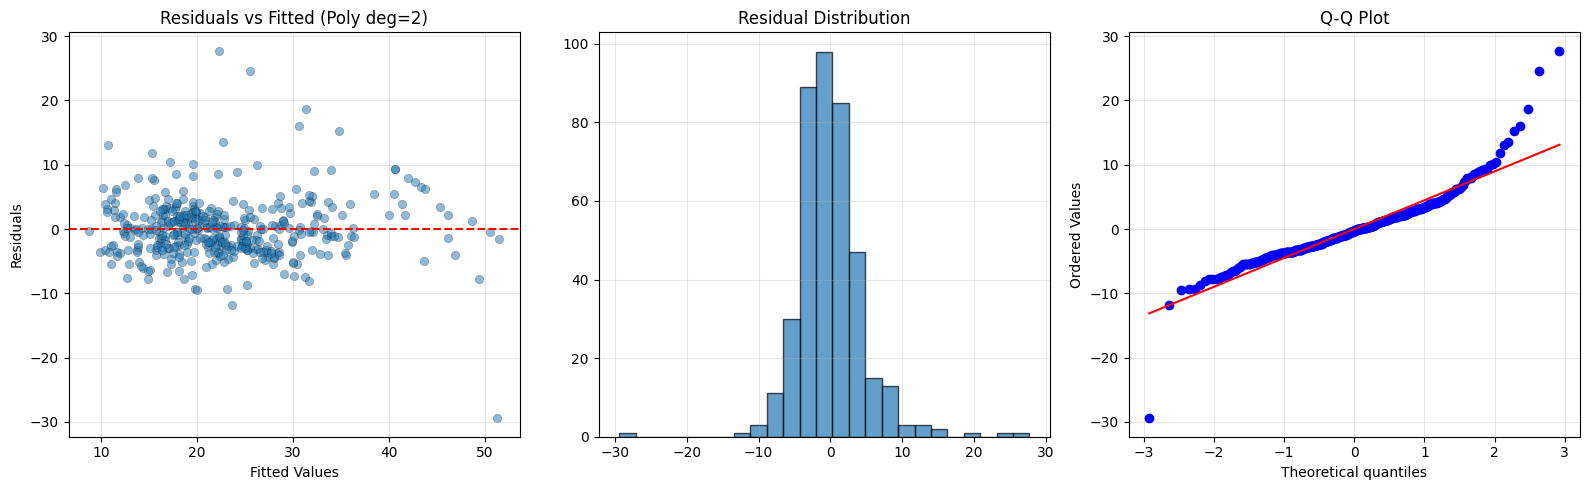

In [24]:
# Residual analysis (degree 2)
residuals_p2 = y_train.values - y_train_pred_p2

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].scatter(y_train_pred_p2, residuals_p2, alpha=0.5, edgecolors='k', linewidths=0.3)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted (Poly deg=2)')
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals_p2, bins=25, edgecolor='k', alpha=0.7)
axes[1].set_title('Residual Distribution')
axes[1].grid(True, alpha=0.3)

probplot(residuals_p2, plot=axes[2])
axes[2].set_title('Q-Q Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Assumption checks (degree 2)
dw_p2 = durbin_watson(residuals_p2)
X_p2_const = sm.add_constant(X_train_poly2)
bp_stat2, bp_p2, _, _ = het_breuschpagan(residuals_p2, X_p2_const)
shap_stat2, shap_p2 = shapiro(residuals_p2)

print(f"Durbin-Watson: {dw_p2:.4f}  (≈2 = no autocorrelation)")
print(f"Breusch-Pagan: p-value = {bp_p2:.4f}  (>0.05 = homoscedastic)")
print(f"Shapiro-Wilk:  p-value = {shap_p2:.6f}  (>0.05 = normal)")

Durbin-Watson: 2.0495  (≈2 = no autocorrelation)
Breusch-Pagan: p-value = 0.0000  (>0.05 = homoscedastic)
Shapiro-Wilk:  p-value = 0.000000  (>0.05 = normal)


The U-shape in the residuals is gone, which confirms the polynomial terms captured the non-linearity that the linear model missed. Durbin-Watson at 2.05 is perfect. However Breusch-Pagan now fails (p ≈ 0), indicating heteroscedasticity. Looking at the residuals-vs-fitted plot, the spread is wider for higher fitted values. This makes sense: expensive homes have more price variability. Shapiro-Wilk still fails, so residuals aren't normal either. For prediction purposes these violations don't invalidate the model, but confidence intervals on coefficients would be unreliable. If we needed valid inference, we'd use robust standard errors or a log transform on the target.

In [26]:
# Cross-validation comparison
cv_r2_p2 = cross_val_score(lr_poly2, X_train_poly2, y_train, cv=5, scoring='r2')
cv_r2_p3 = cross_val_score(lr_poly3, X_train_poly3, y_train, cv=5, scoring='r2')
cv_r2_p4 = cross_val_score(lr_poly4, X_train_poly4, y_train, cv=5, scoring='r2')

print(f"Degree 2 CV R²: {cv_r2_p2.mean():.4f} +/- {cv_r2_p2.std():.4f}")
print(f"Degree 3 CV R²: {cv_r2_p3.mean():.4f} +/- {cv_r2_p3.std():.4f}")
print(f"Degree 4 CV R²: {cv_r2_p4.mean():.4f} +/- {cv_r2_p4.std():.4f}")

Degree 2 CV R²: 0.7105 +/- 0.1138
Degree 3 CV R²: 0.6615 +/- 0.1116
Degree 4 CV R²: 0.6255 +/- 0.1745


Cross-validation confirms what the test set showed. Degree 2 has the best CV R-squared at 0.71 and the lowest standard deviation. Degree 3 drops to 0.66 and degree 4 to 0.63 with increasing variance. The higher degrees are clearly overfitting. The CV standard deviations also grow with degree (0.11, 0.11, 0.17), meaning the higher-degree models are less stable across different data splits.

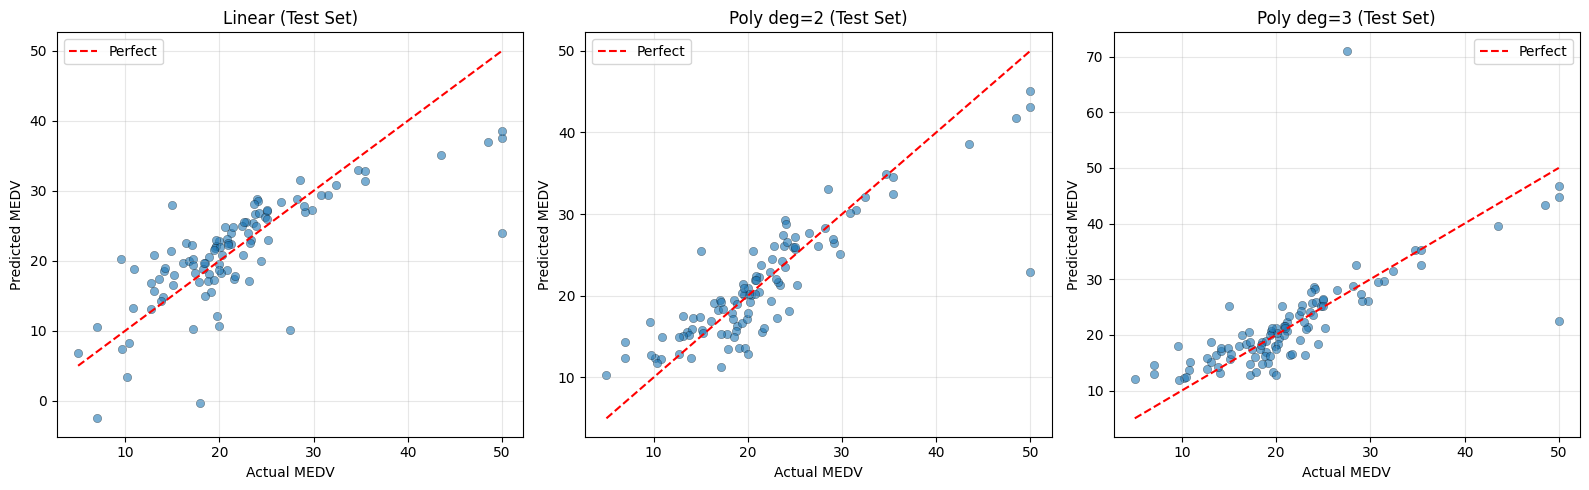

In [27]:
# Actual vs Predicted for all models
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
min_val = min(y_test.min(), 5)
max_val = max(y_test.max(), 50)

for ax, y_pred, title in [
    (axes[0], y_test_pred_lr, 'Linear'),
    (axes[1], y_test_pred_p2, 'Poly deg=2'),
    (axes[2], y_test_pred_p3, 'Poly deg=3'),
]:
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidths=0.3)
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
    ax.set_xlabel('Actual MEDV')
    ax.set_ylabel('Predicted MEDV')
    ax.set_title(f'{title} (Test Set)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# Summary comparison table
from sklearn.metrics import mean_absolute_error

print(f"{'Model':<15} | {'Train RMSE':>10} | {'Test RMSE':>10} | {'Train R²':>10} | {'Test R²':>10} | {'CV R²':>10}")
print("-" * 80)
for name, y_tr_pred, y_te_pred, cv_r2 in [
    ("Baseline", baseline.predict(X_train_scaled), baseline_pred, np.array([0])),
    ("Linear", y_train_pred_lr, y_test_pred_lr, cv_r2_lr),
    ("Poly deg=2", y_train_pred_p2, y_test_pred_p2, cv_r2_p2),
    ("Poly deg=3", y_train_pred_p3, y_test_pred_p3, cv_r2_p3),
    ("Poly deg=4", y_train_pred_p4, y_test_pred_p4, cv_r2_p4),
]:
    tr_rmse = np.sqrt(mean_squared_error(y_train, y_tr_pred))
    te_rmse = np.sqrt(mean_squared_error(y_test, y_te_pred))
    tr_r2 = r2_score(y_train, y_tr_pred)
    te_r2 = r2_score(y_test, y_te_pred)
    print(f"{name:<15} | {tr_rmse:>10.4f} | {te_rmse:>10.4f} | {tr_r2:>10.4f} | {te_r2:>10.4f} | {cv_r2.mean():>10.4f}")

Model           | Train RMSE |  Test RMSE |   Train R² |    Test R² |      CV R²
--------------------------------------------------------------------------------
Baseline        |     9.3206 |     8.6629 |     0.0000 |    -0.0233 |     0.0000
Linear          |     5.6095 |     5.6103 |     0.6378 |     0.5708 |     0.6181
Poly deg=2      |     4.7233 |     4.2903 |     0.7432 |     0.7490 |     0.7105
Poly deg=3      |     4.5295 |     6.0708 |     0.7638 |     0.4974 |     0.6615
Poly deg=4      |     4.2618 |     5.7268 |     0.7909 |     0.5528 |     0.6255


Degree 2 is the clear winner. It has the best test RMSE (4.29), best test R-squared (0.75), and best CV R-squared (0.71). The linear model underfits and degrees 3-4 overfit. The polynomial degree 2 model captures the curvature in LSTAT and RM without fitting noise. Using just 2 features with quadratic terms, we explain 75% of home price variance, a 31% improvement in test R-squared over the linear model. The remaining 25% would require additional features (like proximity to employment centers, school quality, etc.) or a more flexible model. But for demonstrating polynomial regression, this is a clean result: non-linearity exists, degree 2 captures it, and higher degrees overfit.